<a href="https://colab.research.google.com/github/Mohamed-Maher5/Sentiment-Analysis/blob/main/Sentiment_Analysis_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding,GlobalMaxPooling1D, SpatialDropout1D,LSTM,SimpleRNN,GRU

from google.colab import drive

import re

import nltk
nltk.download('punkt')

import spacy
nlp = spacy.load('en_core_web_sm')

!pip install nlpaug
import nlpaug.augmenter.word as naw

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_csv('/content/tweet_emotions.csv')
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
len(df)

40000

In [ ]:
sentiment_values = df['sentiment'].value_counts()
sentiment_values

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

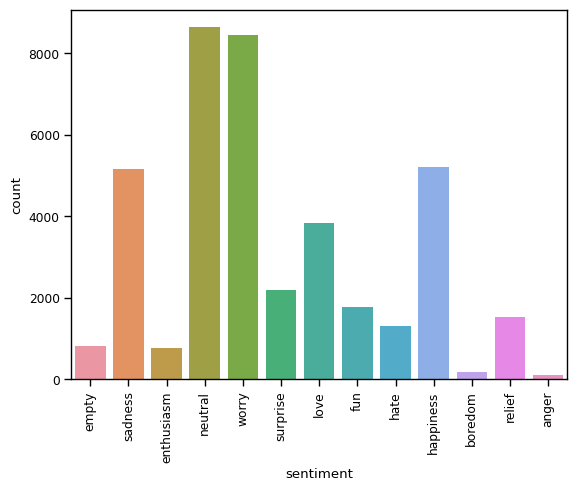

In [ ]:
sns.set_context('paper')
sns.countplot(data=df, x='sentiment')
plt.xticks(rotation=90)
plt.show()

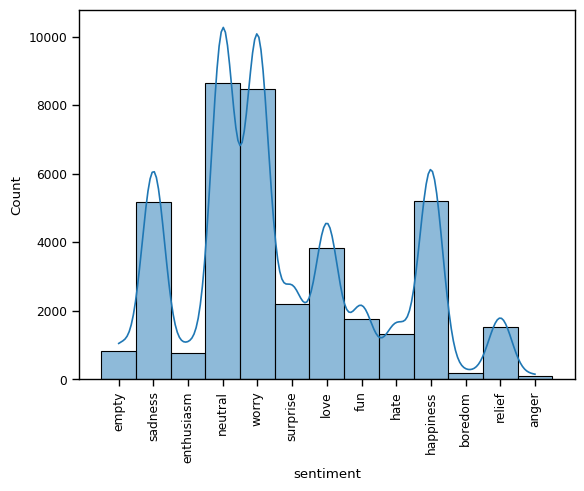

In [ ]:
sns.histplot(x=df['sentiment'], kde=True)
plt.xticks(rotation=90)
plt.show()

In [ ]:
all_words = ' '.join(word for word in df['content'])

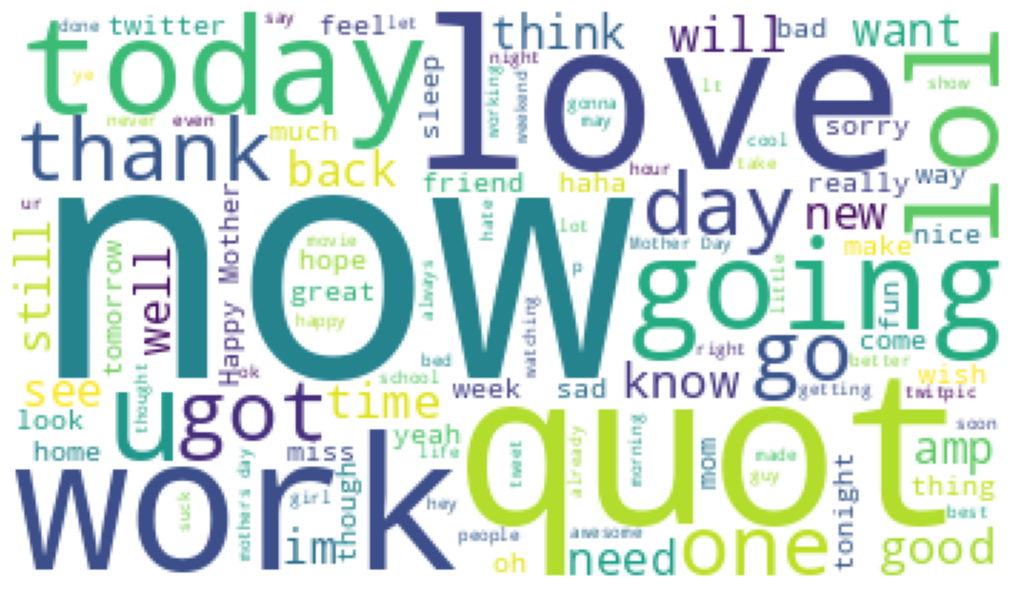

In [ ]:
wordcloud = WordCloud(width = 350,height = 200,background_color = 'white').generate(all_words)
plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [ ]:
df.isnull().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [ ]:
def clean_data(texts):
  cleaned_text = []
  # Remove any HTML, punctuation, whitespace characters and lowercase the words
  for text in texts:
    text = re.sub(r'<[^>]*>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    cleaned_text.append(text.lower())

  return cleaned_text

In [ ]:
cleaned_texts = clean_data(df['content'])
cleaned_texts[:10]

['tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part ',
 'layin n bed with a headache ughhhhwaitin on your call',
 'funeral ceremonygloomy friday',
 'wants to hang out with friends soon',
 'dannycastillo we want to trade with someone who has houston tickets but no one will',
 'repinging ghostridah14 why didnt you go to prom bc my bf didnt like my friends',
 'i should be sleep but im not thinking about an old friend who i want but hes married now damn amp he wants me 2 scandalous',
 'hmmm httpwwwdjherocom is down',
 'charviray charlene my love i miss you',
 'kelcouch im sorry at least its friday']

In [ ]:
def tokenize_data(cleaned_texts):
  cleaned_texts_tokens = []
  for cleaned_text in cleaned_texts:
    tokens = nltk.tokenize.word_tokenize(cleaned_text)
    cleaned_texts_tokens.append(tokens)
  return cleaned_texts_tokens

In [ ]:
cleaned_texts_tokens = tokenize_data(cleaned_texts)
cleaned_texts_tokens[0]

['tiffanylue',
 'i',
 'know',
 'i',
 'was',
 'listenin',
 'to',
 'bad',
 'habit',
 'earlier',
 'and',
 'i',
 'started',
 'freakin',
 'at',
 'his',
 'part']

In [ ]:
def remove_stopwords(texts_tokens):
  cleaned_texts_tokens = []
  for tokens in texts_tokens:
    cleaned_tokens = []
    for token in tokens:
      if token not in nlp.Defaults.stop_words:
        cleaned_tokens.append(token)
    cleaned_texts_tokens.append(cleaned_tokens)
  return cleaned_texts_tokens

In [ ]:
cleaned_texts_tokens = remove_stopwords(cleaned_texts_tokens)
cleaned_texts_tokens[0]

['tiffanylue',
 'know',
 'listenin',
 'bad',
 'habit',
 'earlier',
 'started',
 'freakin']

In [ ]:
cleaned_texts = []
for i in range(len(cleaned_texts_tokens)):
  cleaned_texts.append(" ".join(cleaned_texts_tokens[i]))

In [ ]:
df['cleaned_content'] = cleaned_texts
df.head()

,tweet_id,sentiment,content,cleaned_content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...,tiffanylue know listenin bad habit earlier sta...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,layin n bed headache ughhhhwaitin
2,1956967696,sadness,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
3,1956967789,enthusiasm,wants to hang out with friends SOON!,wants hang friends soon
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,dannycastillo want trade houston tickets


In [ ]:
df = df.drop(['tweet_id','content'], axis=1)
df.head()

,sentiment,cleaned_content
0,empty,tiffanylue know listenin bad habit earlier sta...
1,sadness,layin n bed headache ughhhhwaitin
2,sadness,funeral ceremonygloomy friday
3,enthusiasm,wants hang friends soon
4,neutral,dannycastillo want trade houston tickets


In [ ]:
aug = naw.SynonymAug(aug_src='wordnet')

augmented_data = []
augmented_data_labels = []
for j in range(6):
  for i in range(len(df['cleaned_content'])):
    augmented_text = aug.augment(df['cleaned_content'][i])
    augmented_data.append(str(augmented_text))
    augmented_data_labels.append(df['sentiment'][i])

In [ ]:
temp_df = pd.DataFrame({'cleaned_content': augmented_data, 'sentiment': augmented_data_labels})
df = pd.concat([df, temp_df])
df = df.drop_duplicates()
len(df)

240599

In [ ]:
X = df['cleaned_content']
y = df['sentiment']

In [ ]:
len(X),len(y)

(240599, 240599)

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)
y = pd.Series(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)
print('X_train shape -- ', X_train.shape)
print('y_train shape -- ', y_train.shape)
print('X_test shape -- ', X_test.shape)
print('y_test shape -- ', y_test.shape)

X_train shape --  (192479,)
y_train shape --  (192479,)
X_test shape --  (48120,)
y_test shape --  (48120,)


In [ ]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))

max phrase len: 28


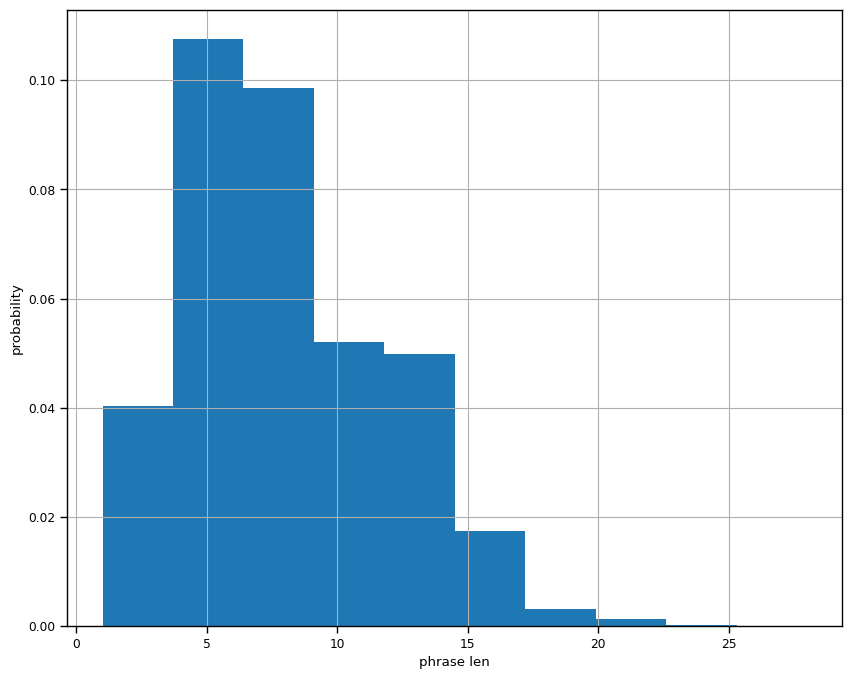

In [ ]:
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid()

In [ ]:
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
y_train = to_categorical(y_train)

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 128, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(128))
model_lstm.add(Dense(128, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(13, activation = 'softmax'))
model_lstm.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [ ]:
history = model_lstm.fit(X_train,y_train,validation_split = 0.2,epochs = 100,batch_size=256)

Epoch 1/100
602/602 [==============================] - 43s 65ms/step - loss: 1.9741 - accuracy: 0.3238 - val_loss: 1.8047 - val_accuracy: 0.3926
Epoch 2/100
602/602 [==============================] - 10s 17ms/step - loss: 1.7139 - accuracy: 0.4304 - val_loss: 1.6855 - val_accuracy: 0.4308
Epoch 3/100
602/602 [==============================] - 9s 15ms/step - loss: 1.5406 - accuracy: 0.4842 - val_loss: 1.5812 - val_accuracy: 0.4637
Epoch 4/100
602/602 [==============================] - 6s 9ms/step - loss: 1.4008 - accuracy: 0.5292 - val_loss: 1.5128 - val_accuracy: 0.4882
Epoch 5/100
602/602 [==============================] - 6s 9ms/step - loss: 1.2913 - accuracy: 0.5613 - val_loss: 1.4622 - val_accuracy: 0.5025
Epoch 6/100
602/602 [==============================] - 5s 9ms/step - loss: 1.2034 - accuracy: 0.5884 - val_loss: 1.4239 - val_accuracy: 0.5227
Epoch 7/100
602/602 [==============================] - 6s 9ms/step - loss: 1.1331 - accuracy: 0.6105 - val_loss: 1.3914 - val_accuracy: 0

In [ ]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen = max_phrase_len)
y_test = to_categorical(y_test)

In [ ]:
doc = {"key" : 1,"val" : 2}
for i,j in enumerate(doc):
  print(i,"   ",j)

0     key
1     val


In [ ]:
def get_max_in_every_list_and_set_rest_to_zero(array):
  predictions = np.empty_like(array)
  for i in range(array.shape[0]):
    max_index = np.argmax(array[i])
    predictions[i][max_index] = 1
    predictions[i][~np.equal(array[i], array[i][max_index])] = 0

  return predictions

In [ ]:
predictions = model_lstm.predict(X_test)
predictions = get_max_in_every_list_and_set_rest_to_zero(predictions)
print(predictions[:10])

1504/1504 [==============================] - 5s 4ms/step
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [ ]:
accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy:', accuracy)

Test Accuracy: 0.7096841230257689


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_lstm.save("/content/drive/MyDrive/LSTM-Model/LstmModel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


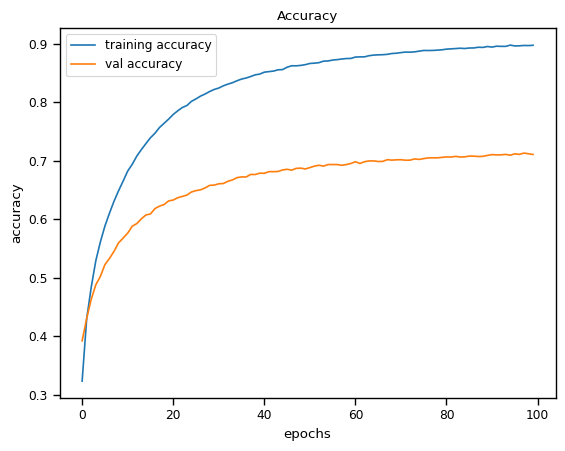

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

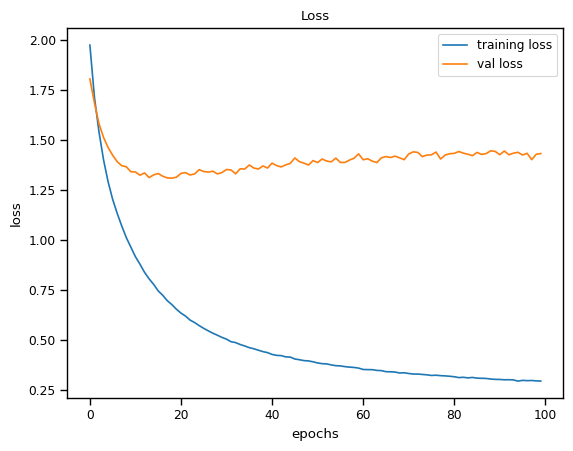

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
labels = ['neutral','worry','happiness','sadness','love','surprise','fun','relief','hate','empty','enthusiasm','boredom','anger']

def get_items_label(array):
  returned_lables = []
  for i in range(len(array)):
    max_index = np.argmax(array[i])
    returned_lables.append(labels[max_index])
  return returned_lables

In [ ]:
predictions = get_items_label(predictions)
y_test = get_items_label(y_test)

<Axes: >

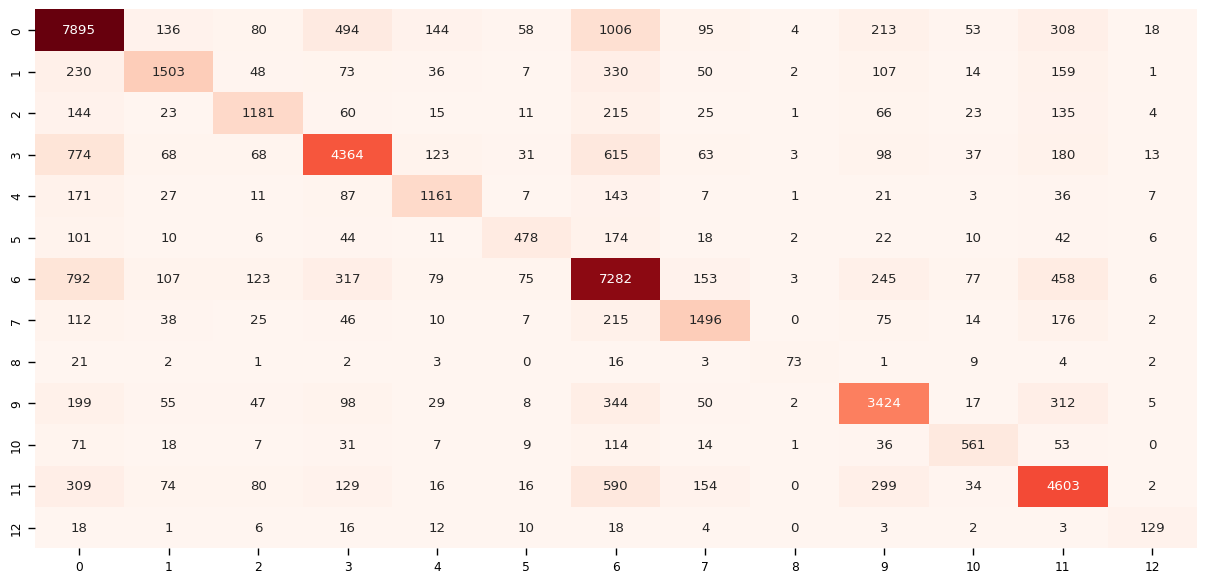

In [ ]:
fig,ax=plt.subplots(figsize=(15,7))
cm = confusion_matrix(y_test,predictions)
sns.heatmap(cm,annot=True,cmap='Reds',fmt="d",cbar=False,ax=ax)

In [ ]:
metrics.classification_report(y_test,predictions)

'              precision    recall  f1-score   support\n\n       anger       0.73      0.75      0.74     10504\n     boredom       0.73      0.59      0.65      2560\n       empty       0.70      0.62      0.66      1903\n  enthusiasm       0.76      0.68      0.72      6437\n         fun       0.71      0.69      0.70      1682\n   happiness       0.67      0.52      0.58       924\n        hate       0.66      0.75      0.70      9717\n        love       0.70      0.68      0.69      2216\n     neutral       0.79      0.53      0.64       137\n      relief       0.74      0.75      0.74      4590\n     sadness       0.66      0.61      0.63       922\n    surprise       0.71      0.73      0.72      6306\n       worry       0.66      0.58      0.62       222\n\n    accuracy                           0.71     48120\n   macro avg       0.71      0.65      0.68     48120\nweighted avg       0.71      0.71      0.71     48120\n'